In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
from subgraphs.sub_graphs_utils import get_sub_graph_mapping_to_motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np

In [55]:
data = import_results('results/pol_k3_m5.bin')
args = data['args']
motifs = data['motifs']
network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table([m for m in motif.polarity_motifs if m.motif_criteria.is_motif != MotifType.none])


Network file name: s1_data.xlsx
Sheet name: 5. Sign prediction
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.757420091324201, '-': 0.2425799086757991})

Network properties:
	Neurons: 283
	Neurons with a Synapse: 283
	Synapses in the network: 11650

	Participating Nodes are neurons in a tuple with at least: 5 synapses
	Synapses in the graph: 9515
	Nodes: 259
	Edges: 661
	Average clustering coefficient: 0.06
	Average shortest path (undirected): 2.038
	Density: 0.01
	Polarity ratios: Counter({'+': 0.7881996974281392, '-': 0.2118003025718608})
	Degree: Mean: 5.104 Std: 4.445 Median: 4.0 Max: 25 (node: RIAL)
	In-Degree: Mean: 2.552 Std: 3.973 Median: 1.0 Max: 23 (node: AVBL)
	Out-Degree: Mean: 2.552 Std: 2.283 Median: 2.0 Max: 13 (node: RIML)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency threshold: 0.1

Sub Graph search using

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    total = sum(sizes)
    for s,l in zip(sizes, labels):
        print(f'{l}: {s}/{total}')

In [26]:
def draw_motif(motif: Motif, ax):
    ax.axis('off')
    
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    ax.set_title(title, fontsize=7.5)

    graph = nx.DiGraph(motif.role_pattern)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax)
    
    if motif.polarity:
        for role, pol in zip(motif.role_pattern, motif.polarity):
            s,t = role
            graph[s][t]['polarity'] = 'c' if pol == 'complex' else pol

        edge_labels=dict([((u,v,),d['polarity']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='k', font_weight='bold', label_pos=0.3)

In [6]:
def plot_motifs_z(motifs_list: list[Motif], motif_type: MotifType, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    plt.figure()
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot of the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2, 2))
    fig.set_size_inches(num_of_graphs*2, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        draw_motif(motif, ax_)

In [36]:
def plot_motif_roles(motif: Motif, top=5):
    roles = motif.node_roles.keys()
    num_of_rows = len(roles)
    if num_of_rows == 0:
        print(f'n_real: {motif.n_real}')
        return
    fig, ax = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(top, 4*num_of_rows))
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 

def get_polarity_index(motif: Motif, polarity: list[str]):
    pol_ids = [m.polarity for m in motif.polarity_motifs]
    return pol_ids.index(polarity)

In [8]:
def node_properties(node: Union[str, int]):
    print(f'Node {node} properties:')
    
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    print(f'Degree: {network.graph.degree[node_idx]}')
    print(f'Out Degree: {network.graph.out_degree[node_idx]}')
    print(f'In Degree: {network.graph.in_degree[node_idx]}')
    print(f'Clustering coefficient: {round(nx.average_clustering(network.graph, nodes=[node_idx]), 3)}')

    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x:y for x,y in node_freq_in_motifs.items() if y!=0}
    
    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))
    plt.figure()
    plt.title(f'Appearance of node: {node} in sub-graphs')
    plt.ylabel('Frequency')
    plt.xlabel('Sub-graph id')

    plt.bar(freq_sorted.keys(), freq_sorted.values())
    plt.show()

In [9]:
def get_motif_sub_graphs_of_node(motif: Motif, node: Union[str, int], role: str, print_neuron_names=True):
    motif_name = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    print(f'Node "{node}" as role "{role}" - sub graphs in Motif {motif_name}:')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 
    
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    for sub_graph in motif.sub_graphs:
        role_nodes_mapping = get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern)
        if role_nodes_mapping[role] != node_idx:
            continue
            
        if network.neuron_names:
            role_nodes_mapping_w_neuron_names = {k:network.neuron_names[role_nodes_mapping[k]] for k in role_nodes_mapping}

        roles_to_print = role_nodes_mapping_w_neuron_names if print_neuron_names else role_nodes_mapping
        print(roles_to_print)


In [10]:
def draw_sub_graph(neurons: list[str], center=None):
    node_list = [network.neuron_names.index(neuron) for neuron in neurons]
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    
    induced_sub_graph = nx.induced_subgraph(network.graph, node_list)
    mapping = {i: n for i, n in enumerate(network.neuron_names)}
    graph = nx.relabel_nodes(induced_sub_graph, mapping)
    
    pos = nx.circular_layout(graph)
    if center:
        pos[center] = np.array([0, 0])
    nx.draw_networkx(graph, pos=pos, ax=ax, node_size=600, node_color='lightgreen')
    
    edge_labels = nx.get_edge_attributes(graph, 'polarity')
    nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=edge_labels, font_color='k', font_weight='bold', label_pos=0.2)

def draw_neighbors(neuron: str):
    neighbors = [network.neuron_names[i] for i in list(network.graph.neighbors(network.neuron_names.index(neuron)))]
    neighbors.append(neuron)
    draw_sub_graph(neighbors, center=neuron)

motif: 7/13
anti-motif: 3/13
none: 3/13


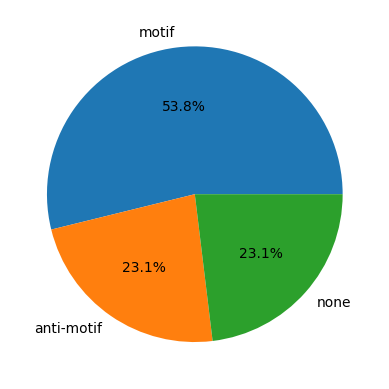

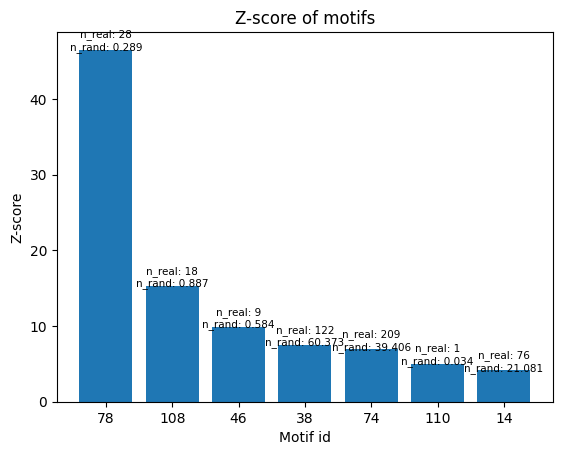

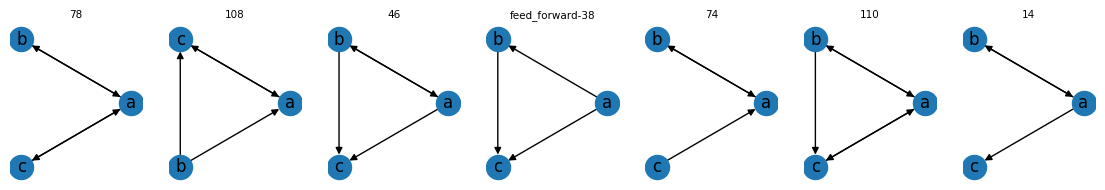

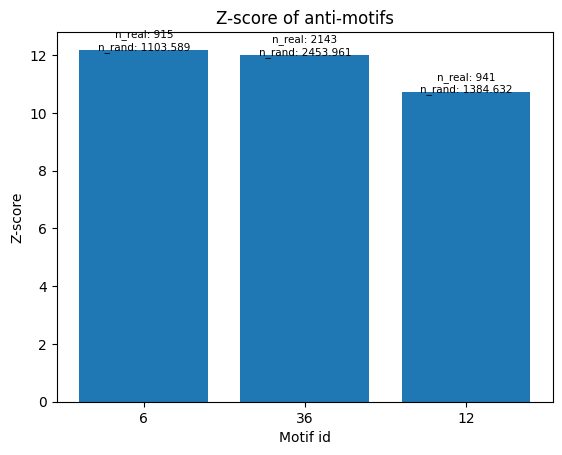

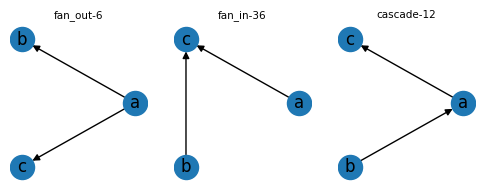

In [56]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

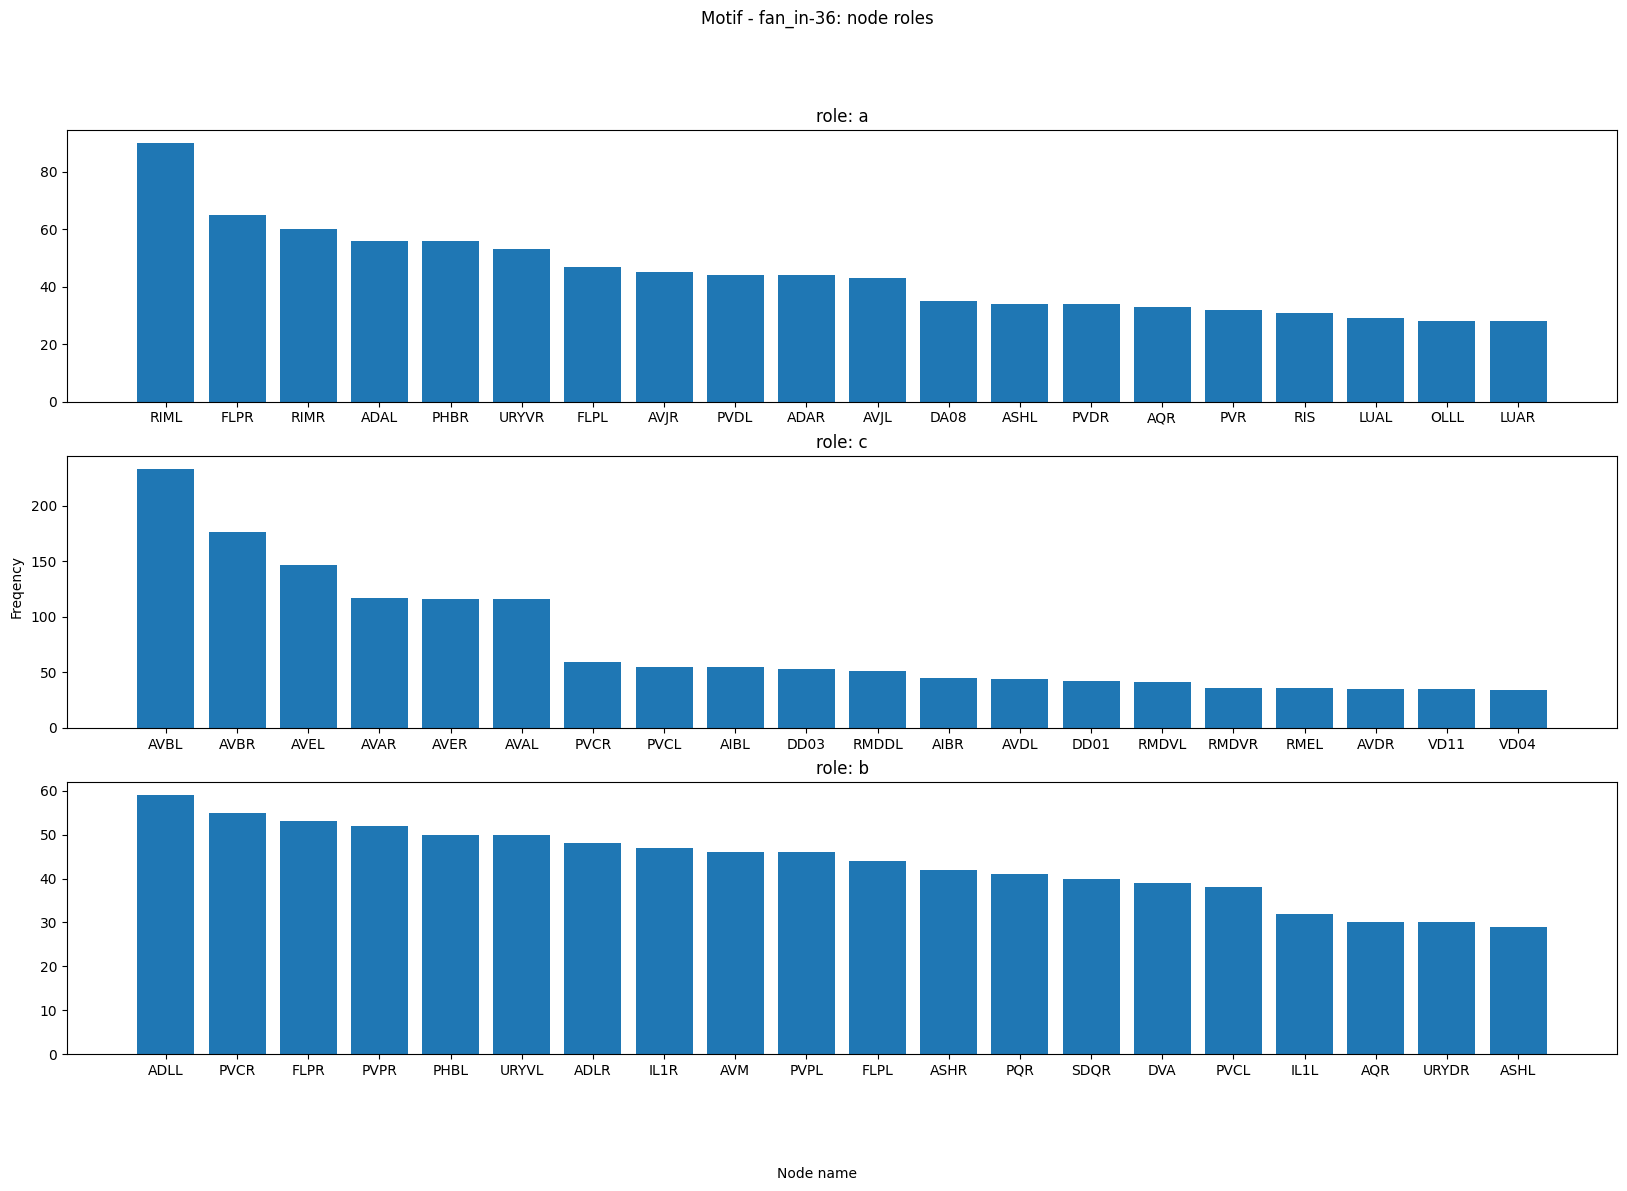

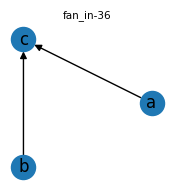

In [57]:
plot_motif_roles(motifs[36], top=20)

Node "LUAR" as role "a" - sub graphs in Motif fan_in-36:
{'a': 'LUAR', 'c': 'AVAL', 'b': 'ADLL'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'ADLL'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'AIBL'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'ADLR'}
{'a': 'LUAR', 'c': 'PVCR', 'b': 'PVCL'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'ASHL'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'ASHL'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'ASHL'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'ASHR'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'DVC'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'FLPL'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'FLPR'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'PHBL'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'PHCL'}
{'a': 'LUAR', 'c': 'AVAL', 'b': 'PQR'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'FLPL'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'FLPR'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'PHBL'}
{'a': 'LUAR', 'c': 'AVDL', 'b': 'PQR'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'FLPL'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'FLPR'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'PHBR'}
{'a': 'LUAR', 'c': 'AVDR', 'b': 'PQR'}
{'a': 'LUAR', 'c': 'PVCR', 

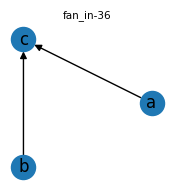

In [58]:
get_motif_sub_graphs_of_node(motifs[36], node='LUAR', role='a')

Node RIAR properties:
Degree: 20
Out Degree: 10
In Degree: 10
Clustering coefficient: 0.062


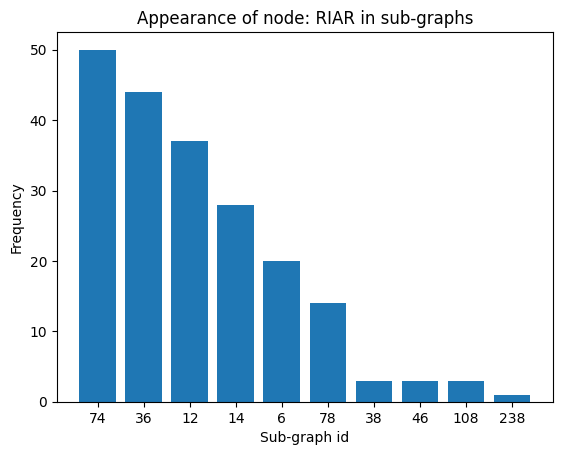

In [59]:
node_properties('RIAR')

Polarity

motif: 18/204
anti-motif: 6/204
none: 180/204


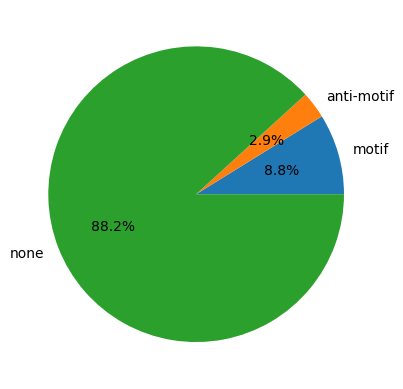

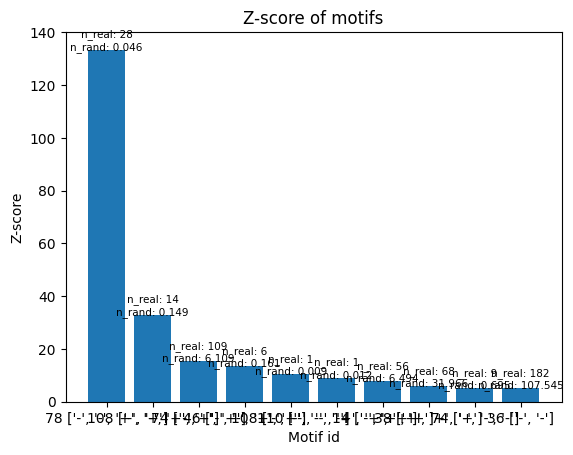

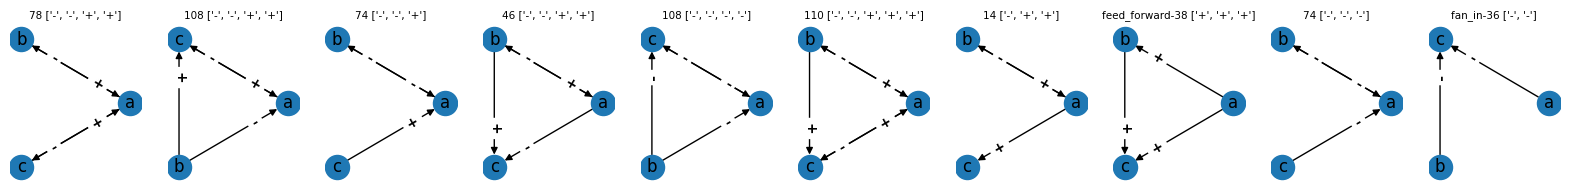

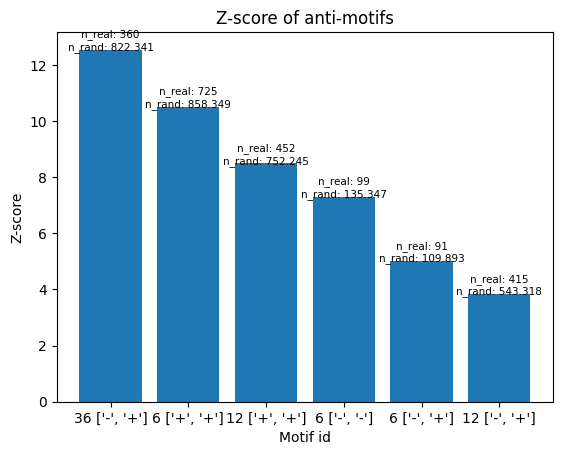

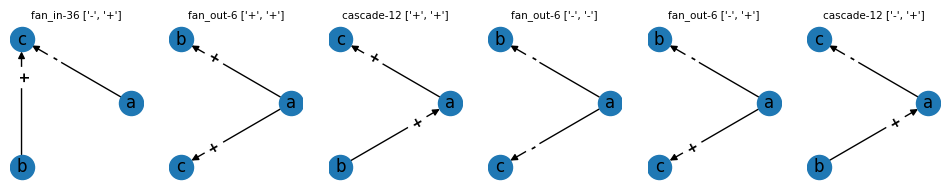

In [60]:
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

In [66]:
# for m in motif.polarity_motifs:
#     print(m.polarity)

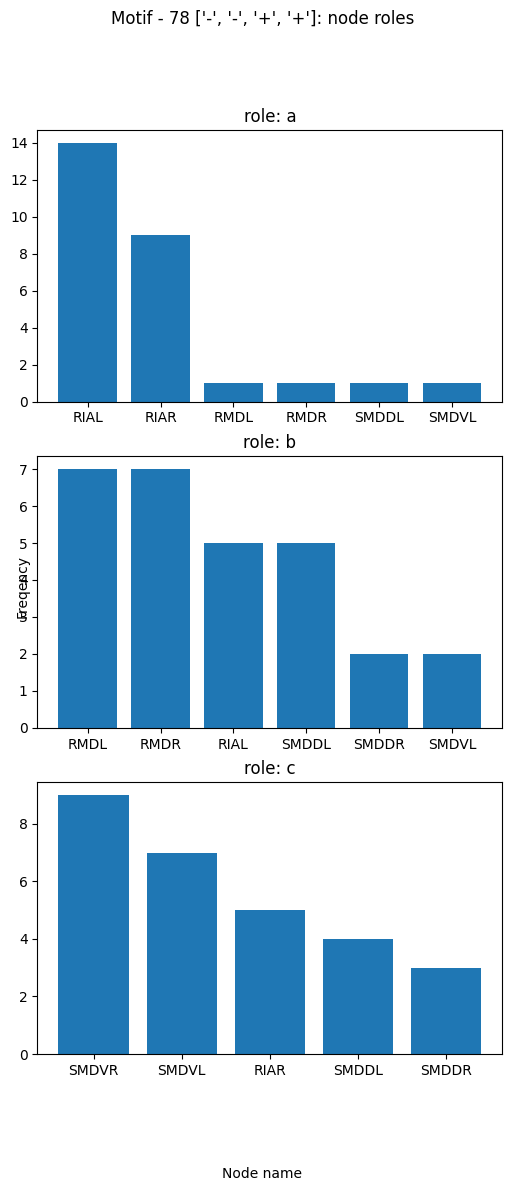

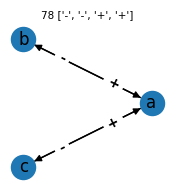

In [68]:
motif = motifs[78]
#polarity = ['complex', '-', 'complex', '+']
polarity = ['-', '-', '+','+']
pol_idx = get_polarity_index(motif, polarity)
plot_motif_roles(motif.polarity_motifs[pol_idx], top=6)

Node "RIAR" as role "a" - sub graphs in Motif 78 ['-', '-', '+', '+']:
{'b': 'RMDL', 'a': 'RIAR', 'c': 'SMDDL'}
{'b': 'RMDL', 'a': 'RIAR', 'c': 'SMDVL'}
{'b': 'RMDL', 'a': 'RIAR', 'c': 'SMDVR'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDDL'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDVL'}
{'b': 'RMDR', 'a': 'RIAR', 'c': 'SMDVR'}
{'b': 'SMDDL', 'a': 'RIAR', 'c': 'SMDVL'}
{'b': 'SMDDL', 'a': 'RIAR', 'c': 'SMDVR'}
{'b': 'SMDVL', 'a': 'RIAR', 'c': 'SMDVR'}


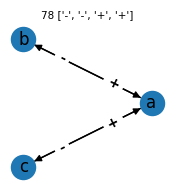

In [69]:
get_motif_sub_graphs_of_node(motif.polarity_motifs[pol_idx], node='RIAR', role='a')

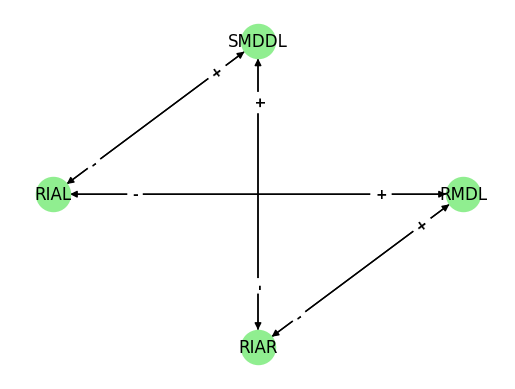

In [70]:
draw_sub_graph(['RMDL', 'RIAL', 'RIAR', 'SMDDL'])

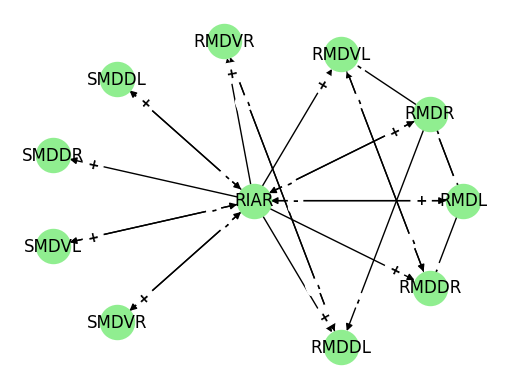

In [71]:
draw_neighbors('RIAR')